# SQL Project - Chinook Database

This project will be using Pythong SQLite to do analysis on the Chinook database. Database information can be found here: https://github.com/lerocha/chinook-database

#### Data Model:
The Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices and customers.

## Importing
Import SQLite, pandas and matplotlib modules using python. Use matplot inline to make plots show in this notebook.

In [41]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline


## Run query to show list of tables and views.

In [42]:
db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as data:
        return pd.read_sql(q, data)

def run_command(c):
    with sqlite3.connect(db) as conn:
        data.isolation_level = None
        data.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## SQL - Show the number of tracks sold for top 10 genre in USA.
Rock genre took 53% of total tracks sold, and Jazz is very unpopular which only got 1%.

In [43]:
usa_top_genre = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY genre
ORDER BY tracks_sold DESC
LIMIT 10;
'''

run_query(usa_top_genre)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


## Visualized data.

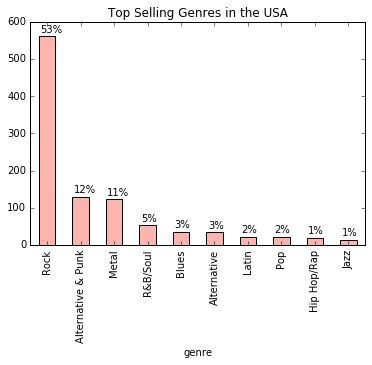

In [44]:
genre_sales_usa = run_query(usa_top_genre)
#Set the index for axis
genre_sales_usa.set_index("genre", inplace=True, drop=True)
#Plot a bar graph
genre_sales_usa["tracks_sold"].plot.bar(
    title="Top Selling Genres in the USA",
    xlim=(0, 1000),
    colormap=plt.cm.Pastel1
)

plt.ylabel('')
for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (i - 0.2, score + 10))


plt.show()

## SQL - Finds the total amount of sales for each sales agent and their information.
Agents that have been working longer tend to get more sales.

In [53]:
agent_sales = '''
WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    e.title,
    e.email,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY employee;
'''

run_query(agent_sales)

,employee,hire_date,title,email,total_sales
0,Jane Peacock,2017-04-01 00:00:00,Sales Support Agent,jane@chinookcorp.com,1731.51
1,Margaret Park,2017-05-03 00:00:00,Sales Support Agent,margaret@chinookcorp.com,1584.00
2,Steve Johnson,2017-10-17 00:00:00,Sales Support Agent,steve@chinookcorp.com,1393.92


## Visualize the data.

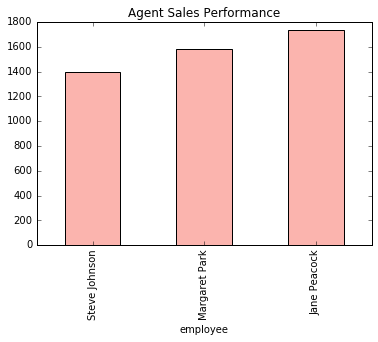

In [51]:
agent_sales_performance = run_query(agent_sales)

agent_sales_performance.set_index("employee", drop=True, inplace=True)
agent_sales_performance.sort_values("total_sales", inplace=True)
agent_sales_performance.plot.bar(
    legend=False,
    title='Agent Sales Performance',
    colormap=plt.cm.Pastel1
)
plt.ylabel('')
plt.show()

## SQL - Breakdown sales into different countries. Countries with only one customer are grouped in to "others" at the end. Include other information such as number of customers, life time values, and average order value.
Using CASE statement.

In [57]:
country_sales = '''
WITH countries_list AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS orders
    FROM countries_list
    GROUP BY country
    ORDER BY orders ASC, total_sales DESC;
'''

run_query(country_sales)

,country,customers,total_sales,customer_lifetime_value,average_order,orders
0,USA,13,1040.49,80.037692,7.942672,0
1,Canada,8,535.59,66.948750,7.047237,0
2,Brazil,5,427.68,85.536000,7.011148,0
3,France,5,389.07,77.814000,7.781400,0
4,Germany,4,334.62,83.655000,8.161463,0
5,Czech Republic,2,273.24,136.620000,9.108000,0
6,United Kingdom,3,245.52,81.840000,8.768571,0
7,Portugal,2,185.13,92.565000,6.383793,0
8,India,2,183.15,91.575000,8.721429,0
9,Other,15,1094.94,72.996000,7.448571,1


## SQL - Are customers buying albums or individual tracks?
Find out if the customer is buying playlist tracks or albums, by looking at the track_id. Identiry whether each invoice has all the tracks from an album. Get the list of tracks from an invoice and compare it to the list of tracks from an album. 


In [68]:
albums_or_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY invoice_id
    )

SELECT
    purchase_type,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id 
                  FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id 
                                      FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id 
                  FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                      )
                   ) IS NULL
             THEN "Album"
             ELSE "Track"
         END AS "purchase_type"
     FROM invoice_first_track ifs
    )
GROUP BY purchase_type;
'''

run_query(albums_or_tracks)                                   

,purchase_type,number_of_invoices,percent
0,Album,114,0.185668
1,Track,500,0.814332
